In [1]:
import sys 
import os
import cymetric as cym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cymetric import graphs as cgr
from cymetric import timeseries as tm
    
%matplotlib inline

In [108]:
db = cym.dbopen('./growthregion/init_reactor_fuelup_n_staggered_cycletimes.sqlite')
ev = cym.Evaluator(db=db, write=False)

# Checking on Type of Fuel in Reactors

In [109]:
def rxtr_enter_exit_total(evaler):
        
    comm = evaler.eval('BuildSeries')
    decomm = evaler.eval('DecommissionSeries')

    neg = -decomm['Count']
    decomm = decomm.drop('Count',axis=1)
    decomm = pd.concat([decomm, neg],axis=1)
    
    comm = comm.rename(columns={'EnterTime':'Time'})
    decomm = decomm.rename(columns={'ExitTime':'Time'})
    
    comm = comm.pivot('Time','Prototype')['Count'].reset_index()
    decomm = decomm.pivot('Time','Prototype')['Count'].reset_index()
    comm_decomm = pd.merge(comm, decomm, left_on='Time', right_on='Time', how='outer', sort=True, \
                           suffixes=('_enter', '_exit')).fillna(0)
    comm_decomm.Time = comm_decomm.Time.astype(int)
    
    # get cumulative sums of _enter and_exit columns for reactors
    # (initially, lwr only...goal is fuel distinction)
    for rx in ['LWR',]:# 'frx']:
        comm_decomm[str(rx) + '_total'] = comm_decomm[str(rx) + '_enter'].cumsum() + \
                                          comm_decomm[str(rx) + '_exit'].cumsum()
    
    return comm_decomm[['Time', 'LWR_total']]

In [110]:
def fuel_quant(evaler):
    
    transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
    transactions = transactions.rename(columns={'TimeCreated':'Time'})
    non = transactions.loc[transactions['Commodity'] == 'UOX_NoAdditive'][['Time', 'Quantity']]
    add = transactions.loc[transactions['Commodity'] == 'UOX_Additive'][['Time', 'Quantity']]
    
    fuel = evaler.eval('TimeList').rename(columns={'TimeStep':'Time'})
    fuel['non_refuel'] = non.groupby(['Time']).sum()['Quantity']
    fuel['add_refuel'] = add.groupby(['Time']).sum()['Quantity']
    fuel.fillna(0, inplace=True)
    fuel['total_refuel'] = fuel['non_refuel'] + fuel['add_refuel']
    fuel = fuel.loc[fuel['total_refuel'] > 0].reset_index(drop=True)
    
    return fuel

In [111]:
def assem_swaps(evaler):
    
    events = evaler.eval('ReactorEvents')
    events = events.loc[(events['Event'] == 'LOAD') | (events['Event'] == 'DISCHARGE')].copy()
    vals = np.asarray(events['Value'].str.split().tolist())[:,0]
    events['Assemblies'] = [int(x) for x in vals]

    assem_swap = events[['Time', 'Event', 'Assemblies']].groupby(['Time', 'Event']).sum().reset_index()
    assem_swap = assem_swap.pivot('Time', 'Event')['Assemblies'].fillna(0).reset_index()
    
    return assem_swap

In [114]:
rxtrs = rxtr_enter_exit_total(ev)
fuels = fuel_quant(ev)
assem_swap = assem_swaps(ev)
#rxtrs

In [113]:
#fuels.loc[fuels['Time'] > 180]

In [112]:
#assem_swap.loc[assem_swap['Time'] > 163]

In [138]:
def fuel_pcts(evaler):
    assem_core = 3
    assem_size = 29565
    intro = 264

    rxtrs = rxtr_enter_exit_total(evaler)
    fuels = fuel_quant(evaler)
    assem_swap = assem_swaps(evaler)

    f = fuels.merge(rxtrs, on='Time', how='outer', sort=True)
    f = f.merge(assem_swap, on='Time', how='outer', sort=True)
    f['LWR_total'] = f[['LWR_total']].fillna(method='ffill')
    f.drop(0, inplace=True)
    f.fillna(0, inplace=True)
    f.reset_index(drop=True, inplace=True)

    # this will need to be per LWR type in the future (but not SFR because it only gets recycled?)
    f['LWR_total_assem'] = assem_core * f['LWR_total']
    f['non_refuel_assem'] = f['non_refuel'] / assem_size
    f['add_refuel_assem'] = f['add_refuel'] / assem_size

# calculating percent of additive v nonadditive fuel
#!!!!!!!******
# presumes that upon introduction, only additive is replacing non-additive
# also (maybe obvious) presumes only non is replacing non in the beginning...
# this allows non_pct and add_pct to stay at 100 & 0, respectively, until additive is introduced
# have to assume discharge is always nonadditive until that runs out.....
# maybe can update with using cumulative sums in certain ranges but right now I think I need to loop through the entire df???
#******!!!!!
# will need to update this for partial-additive assemblies ASAP

    f['non_tally'] = 0
    f['add_tally'] = 0
    non_tally_track = 0
    add_tally_track = 0
    for i, row in f.iterrows():
        #if row['LOAD'] == row['non_refuel_assem']:
        if row['Time'] < intro:
            f.loc[i, 'non_tally'] = row['LWR_total_assem'] #since the math is already done in this col
            non_tally_track = f.loc[i, 'non_tally']
        #elif row['add_refuel_assem'] > 0:
        else: # (row['Time'] >= intro)
            if non_tally_track > 0:
                if non_tally_track - row['DISCHARGE'] < 0: # very last row of stepping down non_tally usually results in negatives
                    f.loc[i, 'non_tally'] = 0
                    f.loc[i, 'add_tally'] = add_tally_track + non_tally_track
                    non_tally_track = 0
                    add_tally_track = f.loc[i, 'add_tally']
                    
                else:
                    f.loc[i, 'non_tally'] = non_tally_track - row['DISCHARGE']
                    non_tally_track = f.loc[i, 'non_tally']
                    # this is the section where cumsum() would be used
                    f.loc[i, 'add_tally'] = add_tally_track + row['LOAD']
                    add_tally_track = f.loc[i, 'add_tally']
            else:
                f.loc[i, 'add_tally'] = row['LWR_total_assem'] #since the math is already done in this col
        
    f['tot_check'] = f['non_tally'] + f['add_tally']
    f['non_pct'] = 100 * f['non_tally'] / f['LWR_total_assem']
    f['add_pct'] = 100 * f['add_tally'] / f['LWR_total_assem']

    # teeny test, should think about others
    check_pct = f['non_pct'] + f['add_pct'] - 100
    assert check_pct.sum() == 0.0

    return f

In [139]:
f = fuel_pcts(ev)
filt = ['Time', 'DISCHARGE', 'LOAD', 'non_refuel_assem', 'add_refuel_assem', 'LWR_total_assem', 'non_tally', 'add_tally', 'tot_check', 'non_pct', 'add_pct']
f[filt].loc[f['Time'] > 305].head(15)

,Time,DISCHARGE,LOAD,non_refuel_assem,add_refuel_assem,LWR_total_assem,non_tally,add_tally,tot_check,non_pct,add_pct
286,306,3.0,0.0,0.0,0.0,297.0,37.0,260.0,297.0,12.457912,87.542088
287,307,4.0,4.0,0.0,4.0,297.0,33.0,264.0,297.0,11.111111,88.888889
288,308,0.0,3.0,0.0,3.0,300.0,33.0,267.0,300.0,11.000000,89.000000
289,310,4.0,4.0,0.0,4.0,300.0,29.0,271.0,300.0,9.666667,90.333333
290,311,7.0,4.0,0.0,4.0,297.0,22.0,275.0,297.0,7.407407,92.592593
291,312,8.0,8.0,0.0,8.0,297.0,14.0,283.0,297.0,4.713805,95.286195
292,313,7.0,10.0,0.0,10.0,300.0,7.0,293.0,300.0,2.333333,97.666667
293,314,6.0,6.0,0.0,6.0,300.0,1.0,299.0,300.0,0.333333,99.666667
294,315,10.0,10.0,0.0,10.0,300.0,0.0,300.0,300.0,0.000000,100.000000
295,316,9.0,6.0,0.0,6.0,297.0,0.0,297.0,297.0,0.000000,100.000000


In [140]:
def plot_fuel_pcts(evaler):
    
    f = fuel_pcts(evaler)
    
    pcts = f[['Time', 'non_pct', 'add_pct']]

    ax = pcts.plot(x='Time', figsize=(11,7), legend=False)
    plt.xlabel('Time (months)',fontsize=20)
    plt.ylabel('Percent (%)',fontsize=20)
    plt.title('Percent Fuel without/with Additive', fontsize=20)
        
    legend = plt.legend(fontsize=14, title='Fuel Type', title_fontsize=14)
    legend.get_texts()[0].set_text('Without Additive')
    legend.get_texts()[1].set_text('With Additive')
        
    ax.minorticks_on()
    ax.tick_params(labelsize=16)
        
    plt.show()

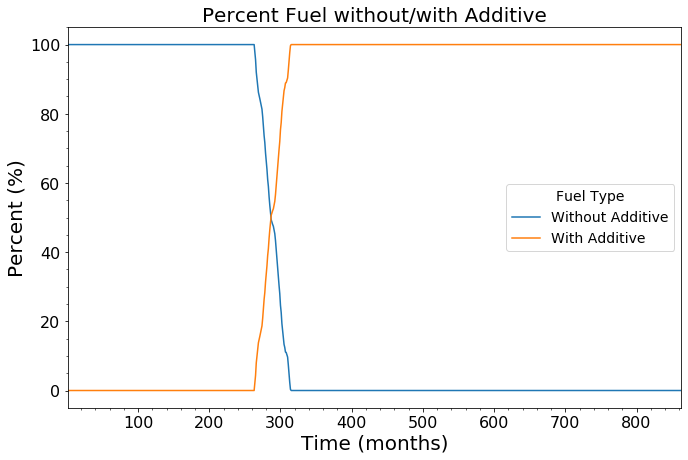

In [141]:
plot_fuel_pcts(ev)

# Mass Flows

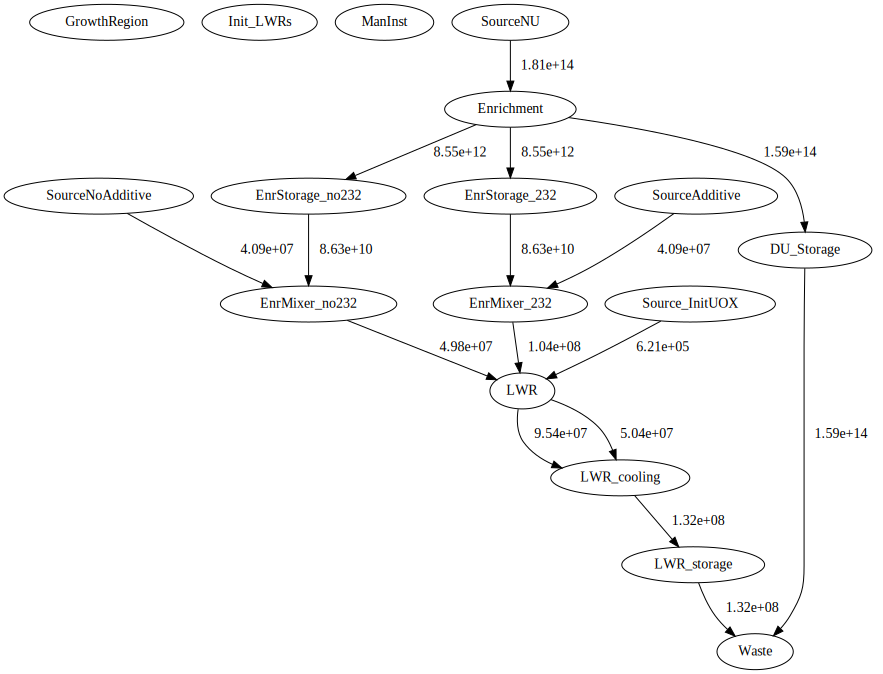

In [88]:
cgr.flow_graph(ev, label='mass')

In [89]:
def plot_flow(evaler, add_or_uox):
    transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
    transactions = transactions.rename(columns={'TimeCreated':'Time'})
    if add_or_uox == 'add':
        non = transactions.loc[transactions['Commodity'] == 'NonAdditive']
        add = transactions.loc[transactions['Commodity'] == 'Additive']
        title = 'Mixer Additives'
    elif add_or_uox == 'uox':
        non = transactions.loc[transactions['Commodity'] == 'AlmostUOX_NoAdditive']
        add = transactions.loc[transactions['Commodity'] == 'AlmostUOX_Additive']
        title = 'Mixer UOX'
    else:
        non = transactions.loc[transactions['Commodity'] == 'NU']
        add = transactions.loc[transactions['Commodity'] == 'AlmostUOX']
        title = 'Enrichment Flow'
    
    flow = pd.DataFrame({'non_flow' : non.groupby(['Time']).sum()['Quantity'],
                         'add_flow' : add.groupby(['Time']).sum()['Quantity']}).reset_index()
    
    # Plotting mass flows at each time step
    ax = flow.plot(x='Time', figsize=(11,7), legend=False)
    plt.xlabel('Time (months)',fontsize=20)
    plt.ylabel('Mass of material flow (kg)',fontsize=20)
    plt.title(title, fontsize=20)
        
    legend = plt.legend(fontsize=14, title='Flow Type', title_fontsize=14)
    legend.get_texts()[0].set_text('Without Additive')
    legend.get_texts()[1].set_text('With Additive')
        
    ax.minorticks_on()
    ax.tick_params(labelsize=16)
    #ax.set_ylim(0, 2.1e10)
        
    plt.show()


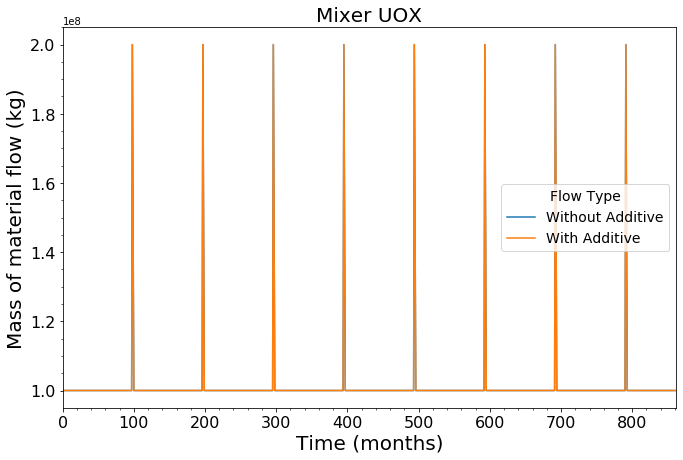

In [90]:
#AlmostUOX
plot_flow(ev, 'uox')

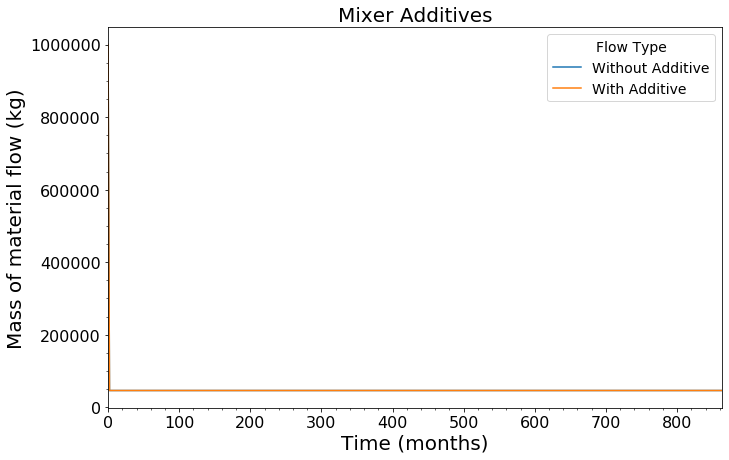

In [91]:
# Additive, NonAdditive
plot_flow(ev, 'add')

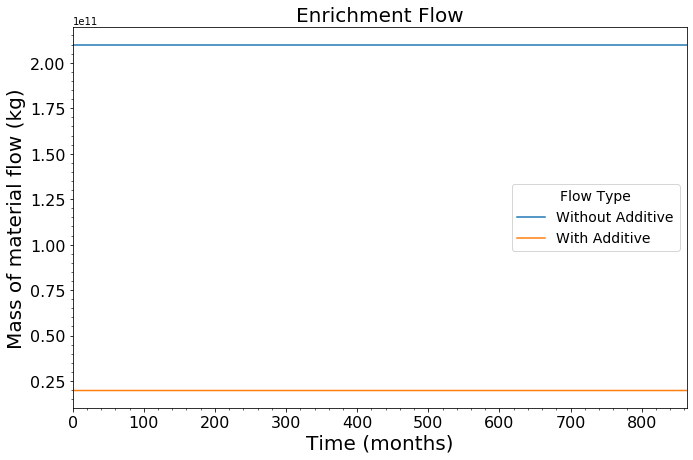

In [92]:
# NU is without A (2.1e11) and AlmostUOX is with A (2e10)
plot_flow(ev, 'enr')

In [93]:
def plot_fuel(evaler, flow_cumul):
    transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
    transactions = transactions.rename(columns={'TimeCreated':'Time'})
    non_fuel = transactions.loc[transactions['Commodity'] == 'UOX_NoAdditive']
    add_fuel = transactions.loc[transactions['Commodity'] == 'UOX_Additive']
    
    if flow_cumul == 'cumul':
        transactions['non_total'] = non_fuel['Quantity'].cumsum()
        transactions['add_total'] = add_fuel['Quantity'].cumsum()
        transactions.fillna(method='ffill', inplace=True)
        transactions['total_fuel'] = transactions['non_total'] + transactions['add_total']

        # Plotting cumulative fuel sent to reactors at each time step
        ax = transactions[['Time', 'non_total', 'add_total', 'total_fuel']].plot(x='Time', figsize=(11,7), legend=False)
        plt.xlabel('Time (months)',fontsize=20)
        plt.ylabel('Mass of fuel fabricated (kg)',fontsize=20)

        legend = plt.legend(fontsize=14, title='Fuel Type', title_fontsize=14)
        legend.get_texts()[0].set_text('UOX without Additive')
        legend.get_texts()[1].set_text('UOX with Additive')
        legend.get_texts()[2].set_text('Total')
    
        ax.minorticks_on()
        ax.tick_params(labelsize=16)

        plt.show()
    elif flow_cumul == 'flow':
        flow = pd.DataFrame({'non_flow' : non_fuel.groupby(['Time']).sum()['Quantity'],
                             'add_flow' : add_fuel.groupby(['Time']).sum()['Quantity']}).reset_index()
        
        # Plotting fuel flow to reactors at each time step
        ax = flow.plot(x='Time', figsize=(11,7), legend=False)
        plt.xlabel('Time (months)',fontsize=20)
        plt.ylabel('Mass of fuel flow to reactors (kg)',fontsize=20)
        
        legend = plt.legend(fontsize=14, title='Fuel Type', title_fontsize=14)
        legend.get_texts()[0].set_text('UOX without Additive')
        legend.get_texts()[1].set_text('UOX with Additive')
        
        ax.minorticks_on()
        ax.tick_params(labelsize=16)
        #ax.set_ylim(0, 20000)
        
        plt.show()
    else: 
        print('Only plots mass flow or cumulative mass of fuel!')
    return

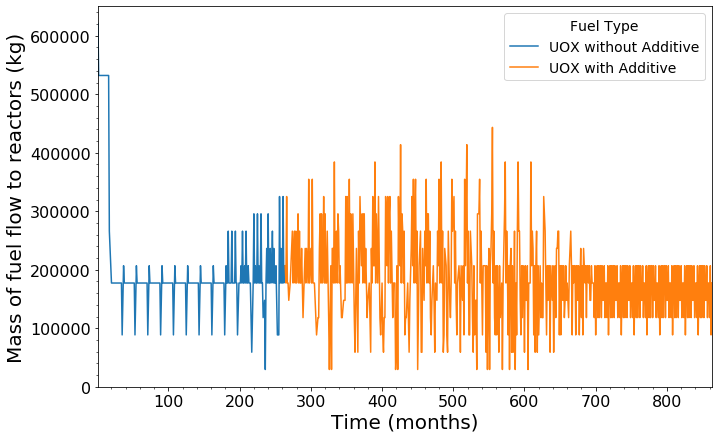

In [94]:
plot_fuel(ev, 'flow')

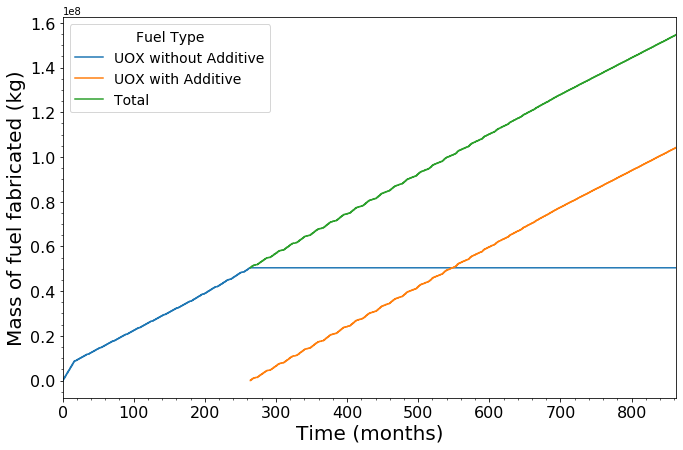

In [95]:
plot_fuel(ev, 'cumul')

# Time Series Power (check constant)

In [96]:
df_tspower = ev.eval('TimeSeriesPower')

# power in GWe
power = df_tspower.groupby(['Time'])['Value'].sum() / 1000.0

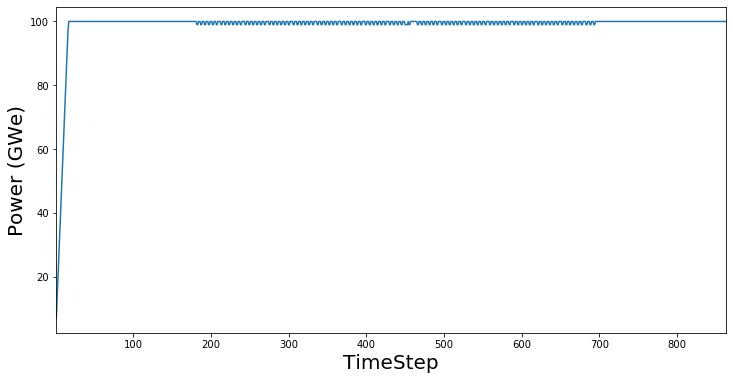

In [98]:
ax = power.plot(x='Time', figsize=(12,6), legend=False)
plt.xlabel(r'TimeStep', fontsize=20)
plt.ylabel(r'Power (GWe)',fontsize=20)
#ax.set_ylim(90, 101)
plt.show()

# Old

# Compare the comm decomm (and cumsums) of reactors in each sim (code from cymetric examples)

In [18]:
def rxtr_enter_exit(evaluator):
        
    comm = evaluator.eval('BuildSeries')
    decomm = evaluator.eval('DecommissionSeries')
    time = evaluator.eval('TimeList')

    neg = -decomm['Count']
    decomm = decomm.drop('Count',axis=1)
    decomm = pd.concat([decomm, neg],axis=1)
    
    comm = comm.rename(columns={'EnterTime':'Time'})
    decomm = decomm.rename(columns={'ExitTime':'Time'})
    
    comm = comm.pivot('Time','Prototype')['Count'].reset_index()
    decomm = decomm.pivot('Time','Prototype')['Count'].reset_index()
    comm_decomm = pd.merge(comm, decomm, left_on='Time', right_on='Time', how='outer', sort=True, \
                           suffixes=('_enter', '_exit')).fillna(0)
    comm_decomm.Time = comm_decomm.Time.astype(int)
    
    #add all sim timesteps
    comm_decomm = pd.concat([comm_decomm, time], axis=1).fillna(0)
    #######################(need to join on time)
    
    return comm_decomm

In [19]:
comm_decom_d = rxtr_enter_exit(evd)
comm_decom_g = rxtr_enter_exit(evg)
#comm_decom_t = rxtr_enter_exit(evt)

In [6]:
data = [comm_decom_d['TimeStep'], 
        comm_decom_d['LWR_enter'], comm_decom_d['LWR_exit'], 
        comm_decom_g['LWR_enter'], comm_decom_g['LWR_exit'], 
        #comm_decom_t['LWR_enter'], comm_decom_t['LWR_exit']
       ]
headers = ['TimeStep', 
           'Enter (d)', 'Exit (d)', 
           'Enter (g)', 'Exit (g)',
           #'Enter (t)', 'Exit (t)'
          ]
plot_df = pd.concat(data, axis=1, keys=headers)

In [ ]:
colors_d = ['green', 'blue']
colors_g = ['purple', 'red']
        
ax = plot_df[['TimeStep', 'Enter (d)', 'Exit (d)']].plot.bar(x='TimeStep', figsize=(20,10), stacked=True, \
                                                              legend=False, color=colors_d, alpha=0.3)
plot_df[['TimeStep', 'Enter (g)', 'Exit (g)']].plot.bar(x='TimeStep', ax=ax, figsize=(20,10), stacked=True, \
                                                       legend=False, color=colors_g, alpha=0.3)
legend = plt.legend()
legend.get_texts()[0].set_text('DeployInst Enter')
legend.get_texts()[1].set_text('DeployInst Exit')
legend.get_texts()[2].set_text('GrowthRegion Enter')
legend.get_texts()[3].set_text('GrowthRegion Exit')
legend.set_title('Reactor Deployments')
plt.xlabel(r'TimeStep', fontsize=18)
plt.ylabel(r'Count', fontsize=18)
plt.show()

In [7]:
plot_df[str('deploy') + '_total'] = comm_decom_d[str('LWR') + '_enter'].cumsum() + \
                                    comm_decom_d[str('LWR') + '_exit'].cumsum()

plot_df[str('growth') + '_total'] = comm_decom_g[str('LWR') + '_enter'].cumsum() + \
                                    comm_decom_g[str('LWR') + '_exit'].cumsum()

#plot_df[str('test') + '_total'] = comm_decom_t[str('LWR') + '_enter'].cumsum() + \
#                                  comm_decom_t[str('LWR') + '_exit'].cumsum()

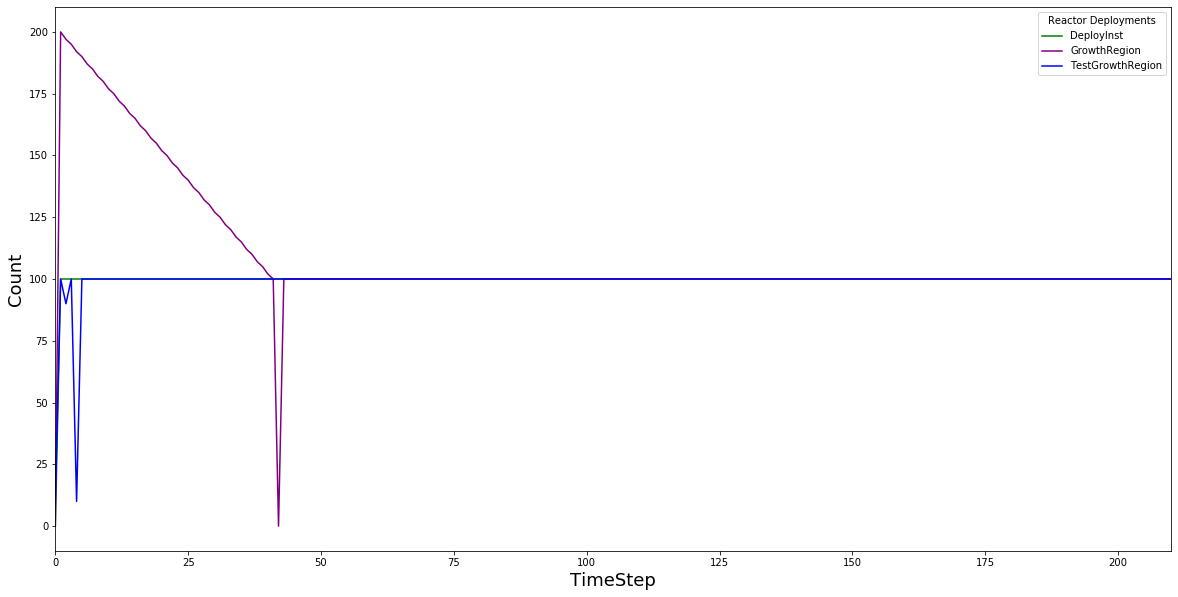

In [45]:
colors = ['green', 'purple']#, 'blue']
ax = plot_df[['TimeStep', 'deploy_total', 'growth_total']].plot(x='TimeStep', figsize=(20,10), \
                                                                legend=False, color=colors)
legend = plt.legend()
legend.get_texts()[0].set_text('DeployInst')
legend.get_texts()[1].set_text('GrowthRegion')
#legend.get_texts()[2].set_text('TestGrowthRegion')
legend.set_title('Reactor Deployments')
plt.xlabel(r'TimeStep', fontsize=18)
plt.ylabel(r'Count',fontsize=18)
#ax.set_ylim(0, 15)
#ax.set_xlim(0, 210)
plt.show()

# Power Steady @ 100 GWe / yr

In [20]:
df_d = evd.eval('TimeSeriesPower')
df_g = evg.eval('TimeSeriesPower')
#df_t = evt.eval('TimeSeriesPower')
# power in GWe
power_d = df_d.groupby(['Time'])['Value'].sum() / 1000.0
power_g = df_g.groupby(['Time'])['Value'].sum() / 1000.0
#power_t = df_t.groupby(['Time'])['Value'].sum() / 1000.0

#power = pd.DataFrame({'deploy_pwr' : power_d, 'growth_pwr' : power_g, 'test_pwr' : power_t}, index=power_d.index).reset_index()
power = pd.DataFrame({'deploy_pwr' : power_d, 'growth_pwr' : power_g}, index=power_d.index).reset_index()

In [21]:
power

,Time,deploy_pwr,growth_pwr
0,1,100.0,100.0
1,2,100.0,100.0
2,3,100.0,100.0
3,4,100.0,100.0
4,5,100.0,100.0
...,...,...,...
1194,1195,100.0,100.0
1195,1196,100.0,100.0
1196,1197,100.0,100.0
1197,1198,100.0,100.0


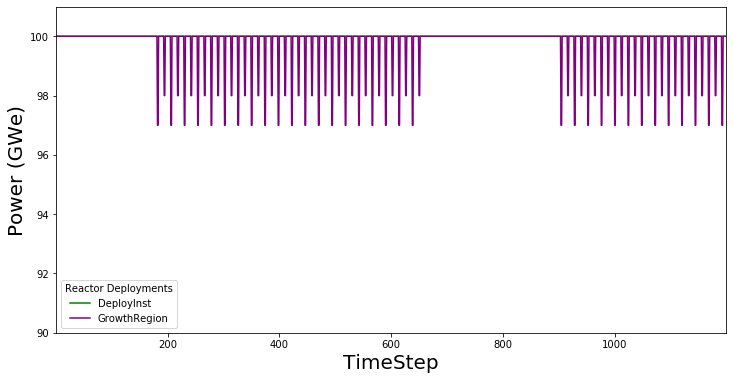

In [32]:
colors = ['green', 'purple']#, 'blue']
ax = power.plot(x='Time', figsize=(12,6), legend=False, color=colors)
legend = plt.legend()
legend.get_texts()[0].set_text('DeployInst')
legend.get_texts()[1].set_text('GrowthRegion')
legend.set_title('Reactor Deployments')
plt.xlabel(r'TimeStep', fontsize=20)
plt.ylabel(r'Power (GWe)',fontsize=20)
ax.set_ylim(90, 101)
plt.show()